In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

Initial Exploration of June 24th, 2017's one week of data

In [2]:
## Setup

In [3]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [4]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.2
Numpy version: 1.12.1


In [5]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('display.precision',3)

In [6]:
# read data
cols = ['control_area', 'unit', 'scp', 'station', 'line_name',\
        'division', 'date', 'time', 'desc','cum_entries', 'cum_exits']
df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt')
df.columns = cols
df.head()

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197416 entries, 0 to 197415
Data columns (total 11 columns):
control_area    197416 non-null object
unit            197416 non-null object
scp             197416 non-null object
station         197416 non-null object
line_name       197416 non-null object
division        197416 non-null object
date            197416 non-null object
time            197416 non-null object
desc            197416 non-null object
cum_entries     197416 non-null int64
cum_exits       197416 non-null int64
dtypes: int64(2), object(9)
memory usage: 16.6+ MB


In [8]:
# check contents of variables
print(df.shape)
print(df.desc.value_counts())
print(df.division.value_counts())

(197416, 11)
REGULAR       196958
RECOVR AUD       458
Name: desc, dtype: int64
IRT    72185
IND    70670
BMT    40102
PTH    12636
SRT     1399
RIT      424
Name: division, dtype: int64


In [9]:
# check turnstile's smallest set of uniquely identifiable variables
# result: a tunstile is unique by control area, scp and station

print(df[['control_area','scp','station']].drop_duplicates().shape)
print(df[['scp','station']].drop_duplicates().shape)
print(df[['control_area','scp','station','unit']].drop_duplicates().shape)


(4700, 3)
(4154, 2)
(4700, 4)


In [10]:
# add datetime variable
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format = '%m/%d/%Y %H:%M:%S')
df.head()

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits,datetime
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317,2017-06-17 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322,2017-06-17 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352,2017-06-17 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452,2017-06-17 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513,2017-06-17 16:00:00


In [11]:
# add shifted data
df[['shift_cum_entries','shift_cum_exits', 'shift_datetime']] = \
                         (df
                         .sort_values(['control_area','scp','station','datetime'])
                         .groupby(['control_area','scp', 'station'])[['cum_entries','cum_exits','datetime']]
                         .shift(1))

df['entries'] = df['cum_entries'] - df['shift_cum_entries']
df['exits'] = df['cum_exits'] - df['shift_cum_exits']
df.head()
#df.iloc[-50:]
#df[['entries','exits']].to_csv('example.csv')

,control_area,unit,scp,station,line_name,division,date,time,desc,cum_entries,cum_exits,datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317,2017-06-17 00:00:00,nan,nan,NaT,nan,nan
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322,2017-06-17 04:00:00,"6,224,816.00","2,107,317.00",2017-06-17 00:00:00,34.00,5.00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352,2017-06-17 08:00:00,"6,224,850.00","2,107,322.00",2017-06-17 04:00:00,35.00,30.00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452,2017-06-17 12:00:00,"6,224,885.00","2,107,352.00",2017-06-17 08:00:00,120.00,100.00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513,2017-06-17 16:00:00,"6,225,005.00","2,107,452.00",2017-06-17 12:00:00,243.00,61.00


In [12]:
df[['entries','exits']].describe()


,entries,exits
count,"192,716.00","192,716.00"
mean,"17,411.97","5,104.51"
std,"5,145,724.07","1,830,591.39"
min,"-5,449,929.00","-2,335,317.00"
25%,11.00,8.00
50%,80.00,54.00
75%,252.00,170.00
max,"1,621,023,313.00","785,938,643.00"


In [13]:
# describe negative/zero values
print('percentage of negative entries:', "{0:.3f}%".format(df[df.entries < 0].shape[0]/df.shape[0]))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.entries == 0].shape[0]/df.shape[0]))
print('percentage of negative exits:', "{0:.3f}%".format(df[df.exits < 0].shape[0]/df.shape[0]))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.exits == 0].shape[0]/df.shape[0]))

# - since negative number's percentage is small, we can take a look at the negative numbers to tell how the numbers are wrong
# - the zero recordings are likely to be from the station closing, or resetting of number
# - we can manually get a sense the outlieres of positive numbers by eyeballing the numbers


percentage of negative entries: 0.008%
percentage of zero entries: 0.142%
percentage of negative exits: 0.006%
percentage of zero entries: 0.140%


### Process negative numbers

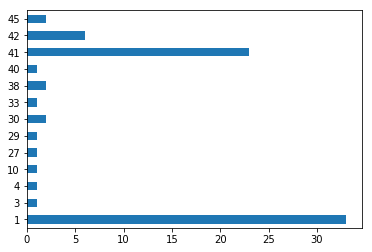

In [14]:
df[df.entries < 0].groupby(['station','control_area','scp'])['entries'].count().value_counts().sort_index().plot('barh')

# vertical axis is numbers of negative entries a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value



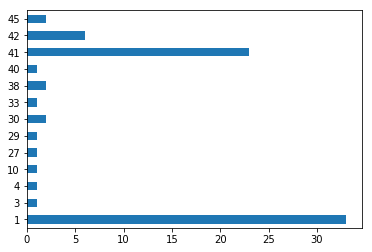

In [15]:
df[df.entries < 0].groupby(['station','control_area','scp'])['exits'].count().value_counts().sort_index().plot('barh')
# vertical axis is numbers of negative exits a turnstile has
# horizental is the count of the number of turnstile with a specific vertical value


In [16]:
# findings: 
# the negative negative entries/eixts either happen singularly (peak in 1), or happen for all periods (peaks in 41-45)

# for now, just process all negative numbers as null values 
# will need to refine the process later 

df.loc[df.entries < 0,'entries'] = np.nan
df.loc[df.exits < 0,'exits'] = np.nan


In [17]:
df[['entries','exits']].describe()


,entries,exits
count,"191,116.00","191,444.00"
mean,"17,648.99","5,198.70"
std,"5,167,194.37","1,836,641.55"
min,0.00,0.00
25%,11.00,9.00
50%,82.00,55.00
75%,254.00,171.00
max,"1,621,023,313.00","785,938,643.00"


### Process Outliers

In [18]:
# investigate outliers for entries

df[df.entries > 4000][['entries','cum_entries','shift_cum_entries']].sort_values('entries')

# it seems that there is a discontunity of data from 4K-ish to more than 150K in entries
# for now, process all entries numbers larger than 5000 as null values


,entries,cum_entries,shift_cum_entries
114465,"4,174.00",4182,8.00
114458,"4,176.00",4182,6.00
114450,"4,178.00",4182,4.00
116212,"150,679.00",258382,"107,703.00"
110390,"185,918.00",209353,"23,435.00"
10433,"631,916.00",1900612,"1,268,696.00"
51981,"150,102,434.00",150995082,"892,648.00"
13339,"1,566,065,984.00",1567690923,"1,624,939.00"
29158,"1,621,023,313.00",1627413160,"6,389,847.00"


In [19]:
# investigate outliers for exits


#df[df.exits > 4000].sort_values('exits')
df[df.exits > 4000][['exits','cum_exits','shift_cum_exits']].sort_values('exits')

# it seems that there is a discontunity of data from 6K-ish to more than 27K in entries
# for now, process all exits numbers larger than 6000 as null values

,exits,cum_exits,shift_cum_exits
49050,"4,038.00",220805578,"220,801,540.00"
152244,"4,116.00",7418279,"7,414,163.00"
152229,"4,120.00",7396318,"7,392,198.00"
48983,"4,243.00",57996403,"57,992,160.00"
48971,"4,270.00",57976625,"57,972,355.00"
48977,"4,329.00",57986455,"57,982,126.00"
49007,"4,821.00",172239779,"172,234,958.00"
48964,"5,512.00",57967162,"57,961,650.00"
114465,"27,341.00",27701,360.00
114458,"27,399.00",27701,302.00


In [20]:
# process outliers
df.loc[df.entries > 5000,'entries'] = np.nan
df.loc[df.exits > 6000,'exits'] = np.nan

In [21]:
df[['entries','exits']].describe()


,entries,exits
count,"191,110.00","191,436.00"
mean,182.32,140.24
std,257.19,232.90
min,0.00,0.00
25%,11.00,9.00
50%,82.00,55.00
75%,254.00,171.00
max,"4,178.00","5,512.00"


In [22]:
## next steps - combine this with the mta-py and plot some simple graphs
